# Modélisation de l'état d'un jeu

In [ ]:
import numpy as np

class State:
    """ Class that describes a state of the 8 puzzle"""

    def __init__(self, values, parent=None):
        """ A state is described by the ordered list of its values, the possible actions on that state"""

        self._values_ = values
        self._actions_ = self.get_possible_actions()
        self._parent_ = parent
        if parent is None:
            self._cost_ = 0
        else:
            self._cost_ = self._parent_._cost_ + 1

    def __eq__(self, other):
        """ Two states are equal if their lists of values are equal"""

        return self._values_ == other._values_

    def __hash__(self):
        """ overriding __eq__ implies redefining __hash__"""

        return id(self._values_)

    def get_possible_actions(self):
        """ Identifying the possible actions in a dictionary where the movable tile is assigned to a sliding action """

        pos_empty = self._values_.index(0)
        possible_actions = {}
        if pos_empty not in [0, 3, 6]:
            possible_actions[pos_empty - 1] = "R"
        if pos_empty not in [2, 5, 8]:
            possible_actions[pos_empty + 1] = "L"
        if pos_empty not in [6, 7, 8]:
            possible_actions[pos_empty + 3] = "U"
        if pos_empty not in [0, 1, 2]:
            possible_actions[pos_empty - 3] = "D"
        return possible_actions

    def generate_next_states(self):
        """ Generating the next states that are possible from the current state based on the possible action """

        pos_empty = self._values_.index(0)
        successors = []
        for key in self._actions_:
            """initializing the values for the child state"""
            values = self._values_.copy()

            """permutation between the movable tile and the empty position"""
            values[pos_empty] = values[key] + values[pos_empty]
            values[key] = values[pos_empty] - values[key]
            values[pos_empty] = values[pos_empty] - values[key]

            """appending the child state to the list of successors"""
            successors.append(State(values, self))
        return successors

    def print_board(self):
        """ Printing the current state in a grid layout """

        board = np.reshape(self._values_, (3, 3))
        for i in range(3):
            print("------------")
            for j in range(3):
                if board[i][j] == 0:
                    print('\33[6m' + '\33[97m' + '\33[47m' + "| " + str(board[i][j]) + " " + '\33[0m', end='')
                else:
                    print('\33[97m' + '\33[44m' "| " + str(board[i][j]) + " " + '\33[0m', end='')
            print("")
        print("------------")

    def heuristic_value(self, heuristic, goal):
        """ Estimating the distance between the current state and the goal based on a given heuristic function """

        return heuristic(self, goal)

    def is_solvable(self, goal):
        """ Test to see if going from the current state to the goal is possible based on the parity of inversions """

        start_values = self._values_.copy()
        goal_values = goal._values_.copy()

        start_values.remove(0)
        goal_values.remove(0)

        def index_mapper_function(element):
            return goal_values.index(element)

        mapped_values = list(map(index_mapper_function, start_values))
        inversions_count = 0
        for i in range(8):
            for j in range(i + 1, 8):
                if mapped_values[i] > mapped_values[j]:
                    inversions_count += 1

        return inversions_count % 2 == 0


# Définition d'une structure de données pour la file de priorité

In [ ]:
import heapq as hpq
import itertools


class PriorityQueueSet:
    """
    Combined priority queue and set data structure.

    The dictionary wrapper guarantees:
        - a unique set of items
        - the possibility to search for items

    and as a result:
        - the possibility to update the priority of an already existing item


    Provides O(1) membership test, O(log N) insertion and O(log N) removal of the smallest item.

    Important: the items of this data structure must be both comparable and
    hashable (i.e. must implement __cmp__ and __hash__). This is true of
    Python's built-in objects, but you should implement those methods if you
    want to use the data structure for custom objects.
    """

    # placeholder for a removed task
    REMOVED = '<removed-task>'

    def __init__(self, items=None):
        """
        Create a new PriorityQueueSet.

        Arguments:
        items (list): An initial item list - it can be unsorted and
        non-unique. The data structure will be created in O(N).

        Attributes:
            self.set: dictionary wrapper for the heap
            self.heap: the actual priority queue
            self.counter: unique sequence count
        """

        if items is None:
            items = []
        self.set = dict((item, []) for item in items)
        self.heap = list(self.set.keys())
        hpq.heapify(self.heap)
        self.counter = itertools.count()

    def has_item(self, item):
        """Check if ``item`` exists in the queue."""
        return item in self.set

    def get_priority(self, item):
        """Get the priority of ``item`` if it exists."""
        try:
            return self.set[item][0]
        except KeyError:
            print("Can't get priority of non-existing item")

    def pop(self):
        """Remove and return the lowest priority task. Raise KeyError if empty."""
        while self.heap:
            priority, count, smallest = hpq.heappop(self.heap)
            if smallest is not self.REMOVED:
                del self.set[smallest]
                return priority, smallest
        raise KeyError('pop from an empty priority queue')

    def remove(self, item):
        """Mark an existing task as REMOVED."""
        try:
            entry = self.set.pop(item)
            entry[-1] = self.REMOVED
        except KeyError:
            print("Can't remove a non-existing item")

    def add(self, item, priority=0):
        """Add a new item or update the priority of an existing task"""
        if item in self.set:
            self.remove(item)
        count = next(self.counter)
        entry = [priority, count, item]
        self.set[item] = entry
        hpq.heappush(self.heap, entry)


# Définition des heuristiques

In [ ]:
"""This heuristic function calculates the number of falsely placed tiles compared to the goal"""


def falsely_positioned_tiles(initial_state, final_state):
    sum_false_positions = 0
    for i in range(9):
        if initial_state._values_[i] != 0 and initial_state._values_[i] != final_state._values_[i]:
            sum_false_positions = sum_false_positions + 1
    return sum_false_positions


"""This heuristic function is based on calculating the sum of manhattan distances
   between the initial and final position of each tile"""


def sum_manhattan_distance(initial_state, final_state):
    i_values = initial_state._values_
    f_values = final_state._values_
    s = 0
    for k in range(1, 9):
        xi = i_values.index(k) // 3
        yi = i_values.index(k) % 3
        xf = f_values.index(k) // 3
        yf = f_values.index(k) % 3
        s = s + abs(xi - xf) + abs(yi - yf)
    return s


# Implémentation de l'algorithme A*

In [ ]:
import matplotlib.pyplot as plt

"""
The a_star function implements the a_star algorithm and returns the total number of visited nodes
"""


def a_star(initial, final, heuristic):
    open_queue = PriorityQueueSet()
    closed_queue = []

    open_queue.add(initial, initial.heuristic_value(heuristic, final))

    while len(open_queue.heap) != 0:

        priority, current_state = open_queue.pop()

        if current_state.heuristic_value(heuristic, final) == 0:
            if len(closed_queue) != 0:
                optimal_path = reconstitute_path(closed_queue[-1], final)
                optimal_path.reverse()
                for state in optimal_path:
                    state.print_board()
                plot_path(closed_queue, optimal_path)

            return len(closed_queue)
        else:
            successors = current_state.generate_next_states()
            for successor in successors:
                h = successor.heuristic_value(heuristic, final)
                g = successor._cost_
                f = g + h
                if not ((successor in closed_queue) or (
                        open_queue.has_item(successor) and (open_queue.get_priority(successor) - h < g))):
                    open_queue.add(successor, f)
            closed_queue.append(current_state)
    return len(closed_queue)


def reconstitute_path(prefinal, final):
    optimal_path = [final]
    current_state = prefinal
    while current_state._parent_ is not None:
        optimal_path.append(current_state)
        current_state = current_state._parent_
    optimal_path.append(current_state)
    return optimal_path


def plot_path(visited, optimal):
    reached_visited = range(0, len(visited))
    reached_optimal = []
    total_optimal_nodes = 0
    for i in reached_visited:
        if optimal[total_optimal_nodes] == visited[i]:
            total_optimal_nodes = total_optimal_nodes + 1
        reached_optimal.append(total_optimal_nodes)

    plt.plot(reached_visited, reached_optimal)
    plt.xlabel("Number of visited nodes")
    plt.ylabel("Number of optimal nodes")
    plt.show()


# Programme principal

Enter the series of numbers for the initial state: 
initial state: 
------------
| 1 | 8 | 2 
------------
| 0 | 4 | 3 
------------
| 7 | 6 | 5 
------------
Enter the series of numbers for the goal state: 
goal state: 
------------
| 1 | 2 | 3 
------------
| 4 | 5 | 6 
------------
| 7 | 8 | 0 
------------
Choose heuristic or quit: 
 1- Sum of manhattan distances 
 2- Number of falsely placed tiles 
 3- Quit
------------
| 1 | 8 | 2 
------------
| 0 | 4 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 8 | 2 
------------
| 4 | 0 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 0 | 2 
------------
| 4 | 8 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 0 
------------
| 4 | 8 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 8 | 0 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 8 | 5 
------------
| 7 | 6 | 0 
------------
------------
| 1 | 2 | 3 
------------

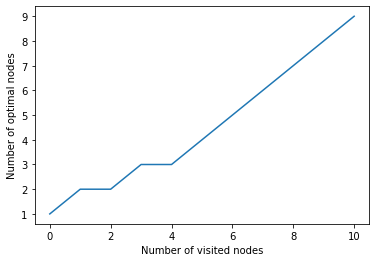

This case was solved! 
  Total of visited nodes =  11
Choose heuristic or quit: 
 1- Sum of manhattan distances 
 2- Number of falsely placed tiles 
 3- Quit
------------
| 1 | 8 | 2 
------------
| 0 | 4 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 8 | 2 
------------
| 4 | 0 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 0 | 2 
------------
| 4 | 8 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 0 
------------
| 4 | 8 | 3 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 8 | 0 
------------
| 7 | 6 | 5 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 8 | 5 
------------
| 7 | 6 | 0 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 8 | 5 
------------
| 7 | 0 | 6 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 0 | 5 
------------
| 7 | 8 | 6 
------------
------------
| 1 | 2 | 3 
------------
| 4 | 5 | 0 
------------
| 7 | 8 | 6 
------------
------------
| 1 | 2 | 

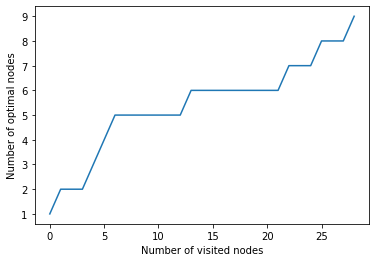

This case was solved! 
  Total of visited nodes =  29
Choose heuristic or quit: 
 1- Sum of manhattan distances 
 2- Number of falsely placed tiles 
 3- Quit


In [ ]:
import re
import os

# Activating colored output on windows cmd
os.system('COLOR')

start = []
goal = []

pattern = re.compile("^([0-9] ){8}[0-9]$")


def input_state(state_name):
    print("Enter the series of numbers for the " + state_name + " state: ")
    values = input("Distinct values in [0,8] range separated by spaces! : ").strip()
    digits = values.split(" ")

    while not pattern.match(values) or sorted([int(item) for item in digits]) != [0, 1, 2, 3, 4, 5, 6, 7, 8]:
        values = input(
            "Wrong format! Please re enter distinct digits in range 0 to 8 separated with spaces: \n ").strip()
        digits = values.split(" ")

    values_list = [int(item) for item in digits]
    return values_list


initial = State(input_state("initial"))
print("initial state: ")
initial.print_board()

goal = State(input_state("goal"))
print("goal state: ")
goal.print_board()

if not initial.is_solvable(goal):
    print('\33[91m' + "This case is not solvable! \n")
else:
    total_visited = 0
    while True:
        print('Choose heuristic or quit: '
              '\n 1- Sum of manhattan distances '
              '\n 2- Number of falsely placed tiles '
              '\n 3- Quit')
        choice = input("Please enter the number of your choice: ")
        while not choice.isnumeric() or int(choice) not in [1, 2, 3]:
            choice = input("Incorrect option! Please reenter the number of your choice: ")

        if int(choice) == 1:
            total_visited = a_star(initial, goal, heuristic=sum_manhattan_distance)
        elif int(choice) == 2:
            total_visited = a_star(initial, goal, heuristic=falsely_positioned_tiles)
        else:
            exit(0)

        print('\33[92m' + "This case was solved! \n  Total of visited nodes =  " + str(total_visited) + '\33[0m')
